In [2]:
import numpy as np
from scipy.stats import norm, t

In [3]:
def estimate_effect_size(std, n, alpha=0.05, power=0.8):
    """
    Расчет MDE для контроля/пилота 50/50, одинаковые std и n
    
    :param std: стандартной отклонение одной группы
    :param n: размер выбрки в одной группе
    :return: MDE
    """
    S = np.sqrt((std**2 / n) + (std**2 / n))
    M = norm.ppf(q=1-alpha/2) + norm.ppf(q=power)
    return M * S


n = 1000
std = 1
estimate_effect_size(std, n)

0.12529069984918345

То есть `effect_size` < 0.17 будет обладать мощностью меньше 80%

In [4]:
def estimate_sample_size(effect_size, std, alpha=0.05, power=0.8):
    """
    Расчет N для контроля/пилота 50/50, одинаковые std и n
    :param std: ско одной группы
    :param effect_size: ожидаемое изменение метрики
    :return: N для одной группы
    """
    M = (norm.ppf(q=1-alpha/2) + norm.ppf(q=power))**2
    return 2 * M * std**2 / effect_size**2 

effect_size = 0.17718780696593192
std = 1
estimate_sample_size(effect_size, std)

500.0

Есть специальная функция !

In [5]:
from statsmodels.stats.power import tt_ind_solve_power 

In [6]:
n = 500
alpha = 0.05
power = 0.8
sd = 1
effect_size = 0.17718780696593192

print(f"""
estimate_sample_size: {estimate_sample_size(effect_size, sd)}
estimate_effect_size: {estimate_effect_size(sd, n)}
tt_ind_solve_power nobs: {
    tt_ind_solve_power(
        effect_size=effect_size,
        alpha=alpha, 
        power=power, 
        ratio=1
    )
}
tt_ind_solve_power effect_size: {
    tt_ind_solve_power(
        nobs1=n, 
        alpha=alpha, 
        power=power, 
        ratio=1
    )
}
""")


estimate_sample_size: 500.0
estimate_effect_size: 0.17718780696593192
tt_ind_solve_power nobs: 500.96095684136526
tt_ind_solve_power effect_size: 0.17735842307242328



_____________________________________________________________________________________________________________________

Критерий Стьюдента (t-test)

In [7]:
N_a = 20
df_a = N_a - 1 # Кол-во степеней свободы для контрольной группы А
N_b = 70 # варьируем
df_b = N_b - 1 # Кол-во степеней свободы для экспериментальной группы B

# Уровень значимости
alpha = 0.05

# Генерируем t-распределение с параметрами контрольной группы А
X_a = np.random.standard_t(df_a,N_a)
# Генерируем t-распределение с параметрами экспериментальной группы B
X_b = np.random.standard_t(df_b,N_b)

# Среднее значение метрики в контрольной группе А
mu_a = np.mean(X_a)
# Среднее значение метрики в экспериментальной группе B
mu_b = np.mean(X_b)

# Выборочная дисперсия метрики в контрольной группе А
sigma_sqr_a = np.var(X_a)
# Выборочная дисперсия метрики в экспериментальной группе B
sigma_sqr_b = np.var(X_b)

# Взвещенная выборочная дисперсия 
pooled_variance_t_test = (
    (N_a-1)*sigma_sqr_a + (N_b -1) * sigma_sqr_b
)/(N_a + N_b-2)*(1/N_a + 1/N_b)

# Взвещенное выборочное стандартное отклонение
SE = np.sqrt(pooled_variance_t_test)

# Тестовая статистика
T = (mu_a-mu_b)/SE

# Критическое значение теста для 2-сторонней гипотезы (распределение стьюдента)
t_crit = t.ppf(1-alpha/2, N_a + N_b - 2)

# P-value для 2-сторонней гипотезы (симметрично)
p_value = t.sf(T, N_a + N_b - 2)*2

# Отклонение
margin_error = t_crit * SE
# Доверительный интервал
CI = [(mu_a-mu_b) - margin_error, (mu_a-mu_b) + margin_error]

print("T-score: ", T)
print("T-critical: ", t_crit)
print("P_value: ", p_value)
print("Confidence Interval of 2 sample Z-test: ", np.round(CI,2))

T-score:  -2.2546817662542815
T-critical:  1.9872898646909385
P_value:  1.9733648548654044
Confidence Interval of 2 sample Z-test:  [-0.98 -0.06]


In [7]:
from scipy.stats import ttest_ind, mannwhitneyu

In [8]:
ttest_ind(
    X_a, 
    X_b,
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)

Ttest_indResult(statistic=0.8814210412007593, pvalue=0.38049109569885464)

Непараметрический тест Манна-Уитни

In [9]:
mannwhitneyu(
    X_a, 
    X_b,
#     nan_policy='propagate',
#     alternative='two-sided'
)

MannwhitneyuResult(statistic=798.0, pvalue=0.34401594258029133)

`p-val` > 0.05  ==> H0 принимаем на этом уровне значимости => различий стат-значимых нет

________________________________________________________________________________________________________

reject the null
7.832495206930039e-11
Test Statistics stat:  6.503782823926798
Z-critical:  1.959963984540054
P_value:  7.832495206930039e-11
Confidence Interval of 2 sample Z-test for proportions:  [0.02 0.04]


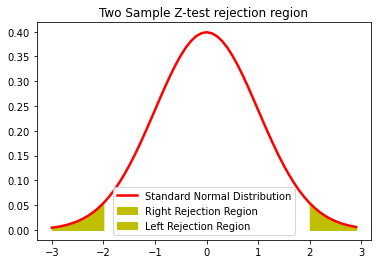

In [10]:
X_a = 1242 # кол-во кликов в контрольной группе А
N_a = 9886 # кол-во показов в контрольной группе А
X_b = 974 # кол-во кликов в экспериментальной группе B
N_b = 10072  # кол-во показов в экспериментальной группе B

# Уровень значимости
alpha = 0.05

p_a_hat = X_a / N_a
p_b_hat = X_b / N_b

p_pooled_hat = (X_a + X_b)/(N_a + N_b)
pooled_variance = p_pooled_hat*(1-p_pooled_hat) * (1/N_a + 1/N_b)

# Выборочное стандартное отклонение
SE = np.sqrt(pooled_variance)

# Тестовая статистика
Test_stat = (p_a_hat - p_b_hat)/SE
# Критическое значение теста для 2-сторонней гипотезы (из норм распределения)
Z_crit = norm.ppf(1-alpha/2)

# Отклонение (ширина доверительного интервала)
# P-value для 2-сторонней гипотезы (симметрично)=> умножаем на два (для правой и левой крит-области)
p_value = norm.sf(Test_stat)*2

# Доверительный интервал
CI = [(p_a_hat-p_b_hat) - SE * Z_crit, (p_a_hat-p_b_hat) + SE * Z_crit]

if np.abs(Test_stat) >= Z_crit:
    print("reject the null")
    print(p_value)

print("Test Statistics stat: ", Test_stat)
print("Z-critical: ", Z_crit)
print("P_value: ", p_value)
print("Confidence Interval of 2 sample Z-test for proportions: ", np.round(CI,2))

import matplotlib.pyplot as plt
z = np.arange(-3,3,  0.1)
plt.plot(z, norm.pdf(z), label = 'Standard Normal Distribution',color = 'red',linewidth = 2.5)
plt.fill_between(z[z>Z_crit], norm.pdf(z[z>Z_crit]), label = 'Right Rejection Region',color ='y' )
plt.fill_between(z[z<(-1)*Z_crit], norm.pdf(z[z<(-1)*Z_crit]), label = 'Left Rejection Region',color ='y' )
plt.title("Two Sample Z-test rejection region")
plt.legend()
plt.show()

In [11]:
p_a_hat, p_b_hat 

(0.12563220716164272, 0.09670373312152503)

In [12]:
from statsmodels.stats.proportion import proportions_ztest

In [13]:
test_stat, p_value = proportions_ztest(np.array([X_a, X_b]), np.array([N_a, N_b]))

In [14]:
p_value

7.832495206930039e-11

____________________________________________________________________________________________________________

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

____________________________________________________________________________________________________________

# Sampling

### Random Sampling

In [16]:
N = 10000
mu = 10
std = 2
population_df = np.random.normal(mu, std, N)

def random_sampling(df, n):
    random_sample = np.random.choice(df, replace = True, size = n)
    return(random_sample)
n = 3000
random_sample_1 = random_sampling(population_df, n)
random_sample_2 = random_sampling(population_df, n)
random_sample_1, random_sample_2, len(random_sample_1), len(random_sample_2)

(array([12.95787816, 11.08679898, 10.11749364, ..., 12.15965363,
         9.40635423, 15.17829621]),
 array([10.48497525, 10.63452872,  8.61340529, ..., 11.46466838,
        10.43686272,  9.25934982]),
 3000,
 3000)

### Systematic Sampling

In [17]:
N = 10000
mu = 10
std = 2
population_df = np.random.normal(mu, std, N)

def systematic_sampling(df, step):
    id = pd.Series(np.arange(1,len(df),1))
    df = pd.Series(df)
    df_pd = pd.concat([id, df], axis = 1)
    df_pd.columns = ["id", "data"]
    
    selected_index = np.arange(1, len(df), step)
    
    systematic_sampling = df_pd.iloc[selected_index]
    return(systematic_sampling)

n_1 = 10
n_2 = 20
step_1 = int(N/n_1)
step_2 = int(N/n_2)
sample_1 = systematic_sampling(population_df, step_1)
sample_2 = systematic_sampling(population_df, step_2)
sample_1, sample_2

(          id       data
 1        2.0   8.576719
 1001  1002.0   7.493966
 2001  2002.0  11.313731
 3001  3002.0  10.159277
 4001  4002.0  11.105986
 5001  5002.0  12.358174
 6001  6002.0  13.694276
 7001  7002.0  10.543882
 8001  8002.0   8.169097
 9001  9002.0   7.895977,
           id       data
 1        2.0   8.576719
 501    502.0   8.702572
 1001  1002.0   7.493966
 1501  1502.0  10.581551
 2001  2002.0  11.313731
 2501  2502.0  11.078108
 3001  3002.0  10.159277
 3501  3502.0  12.491351
 4001  4002.0  11.105986
 4501  4502.0   9.429636
 5001  5002.0  12.358174
 5501  5502.0   6.728822
 6001  6002.0  13.694276
 6501  6502.0   8.754997
 7001  7002.0  10.543882
 7501  7502.0   9.715693
 8001  8002.0   8.169097
 8501  8502.0  10.322268
 9001  9002.0   7.895977
 9501  9502.0   6.455091)

### Cluster Sampling

In [18]:
price_vb = pd.Series(np.random.uniform(1,4,size = N))
id = pd.Series(np.arange(0, len(price_vb),1))
event_type = pd.Series(np.random.choice(["type1", "type2", "type3"],size = len(price_vb)))
click = pd.Series(np.random.choice([0,1], size = len(price_vb)))
df = pd.concat([id, price_vb, event_type, click],axis = 1)
df.columns = ["id", "price", "event_type", "click"]
df

,id,price,event_type,click
0,0,1.749574,type2,1
1,1,1.303651,type1,0
2,2,2.174257,type2,0
3,3,2.796666,type2,1
4,4,3.024540,type2,1
...,...,...,...,...
9995,9995,1.424448,type1,1
9996,9996,3.404156,type3,0
9997,9997,1.859556,type2,0
9998,9998,2.706640,type2,0


In [19]:
def get_clustered_Sample(df, n_per_cluster, num_select_clusters):
    N = len(df)
    K = int(N/n_per_cluster)
    data = None
    for k in range(K):
        sample_k = df.sample(n_per_cluster)
        sample_k["cluster"] = np.repeat(k, len(sample_k))
        df = df.drop(index = sample_k.index)
        data = pd.concat([data,sample_k],axis = 0)

    random_chosen_clusters = np.random.randint(0, K, size = num_select_clusters)
    samples = data[data.cluster.isin(random_chosen_clusters)]
    return(samples)

sample_1 = get_clustered_Sample(df = df, n_per_cluster = 100, num_select_clusters = 2)
sample_2 = get_clustered_Sample(df = df, n_per_cluster = 100, num_select_clusters = 2)
sample_1, sample_2

(        id     price event_type  click  cluster
 4712  4712  2.039724      type2      1       72
 7138  7138  1.003519      type3      0       72
 6770  6770  3.834418      type2      1       72
 4617  4617  2.434569      type1      0       72
 5517  5517  1.764715      type3      1       72
 ...    ...       ...        ...    ...      ...
 9869  9869  3.313602      type2      1       77
 5719  5719  2.112227      type3      1       77
 2731  2731  3.671645      type2      0       77
 3743  3743  3.163267      type3      1       77
 6980  6980  3.265530      type3      0       77
 
 [200 rows x 5 columns],
         id     price event_type  click  cluster
 5462  5462  2.808129      type1      1       14
 9357  9357  3.490501      type2      0       14
 9078  9078  1.274551      type2      1       14
 682    682  1.436488      type1      0       14
 6545  6545  2.466883      type2      1       14
 ...    ...       ...        ...    ...      ...
 2619  2619  2.665747      type2      1   

### Weighted Sampling

In [20]:
def get_weighted_sample(df, n):
    def get_class_prob(x):
        weight_x = int(np.rint(n * len(x[x.click != 0]) / len(df[df.click != 0])))
        sampled_x = x.sample(weight_x).reset_index(drop=True)
        return (sampled_x)

    weighted_sample = df.groupby('event_type').apply(get_class_prob)
#     print(weighted_sample["event_type"].value_counts())
    return (weighted_sample)

sample_1 = get_weighted_sample(df, 100)
sample_2 = get_weighted_sample(df, 100)
sample_1, sample_2

(                 id     price event_type  click
 event_type                                     
 type1      0   9681  1.329625      type1      0
            1    682  1.436488      type1      0
            2   3022  3.046058      type1      1
            3   8701  2.330861      type1      0
            4   6884  3.485850      type1      1
 ...             ...       ...        ...    ...
 type3      27  6585  2.366462      type3      1
            28   782  2.311036      type3      0
            29  6366  1.277768      type3      0
            30  1125  2.652165      type3      0
            31    17  3.911700      type3      0
 
 [99 rows x 4 columns],
                  id     price event_type  click
 event_type                                     
 type1      0   4978  3.165612      type1      0
            1   7469  3.506295      type1      0
            2   8428  3.284926      type1      1
            3   1670  2.644059      type1      0
            4   4077  3.908259      type1  

### Stratified Sampling

In [21]:
def get_startified_sample(df, n, num_clusters_needed):
    N = len(df)
    num_obs_per_cluster = int(N/n)
    K = int(N/num_obs_per_cluster)

    def get_weighted_sample(df,num_obs_per_cluster):
        def get_sample_per_class(x):
            n_x = int(np.rint(num_obs_per_cluster*len(x[x.click !=0])/len(df[df.click !=0])))
            sample_x = x.sample(n_x)
            return(sample_x)
        weighted_sample = df.groupby("event_type").apply(get_sample_per_class)
        return(weighted_sample)

    stratas = None
    for k in range(K):
        weighted_sample_k = get_weighted_sample(df, num_obs_per_cluster).reset_index(drop = True)
        weighted_sample_k["cluster"] = np.repeat(k,len(weighted_sample_k))
        stratas = pd.concat([stratas, weighted_sample_k],axis = 0)
        df.drop(index = weighted_sample_k.index)
    selected_strata_clusters = np.random.randint(0, K, size = num_clusters_needed)
    stratified_samples = stratas[stratas.cluster.isin(selected_strata_clusters)]
    return(stratified_samples)

sample_1 = get_startified_sample(df = df, n = 100, num_clusters_needed = 2)
sample_2 = get_startified_sample(df = df, n = 100, num_clusters_needed = 2)
sample_1, sample_2


(      id     price event_type  click  cluster
 0   4228  3.030472      type1      1       59
 1   4902  3.364415      type1      1       59
 2   7333  3.522493      type1      1       59
 3   1486  1.119640      type1      1       59
 4   5507  3.097000      type1      0       59
 ..   ...       ...        ...    ...      ...
 94  9358  1.620969      type3      0       87
 95  6195  2.400489      type3      1       87
 96  6900  1.006235      type3      0       87
 97  2755  2.612822      type3      1       87
 98  9267  3.560741      type3      1       87
 
 [198 rows x 5 columns],
       id     price event_type  click  cluster
 0   6923  2.588295      type1      1       32
 1   4528  1.896443      type1      1       32
 2   6820  3.696661      type1      0       32
 3   1993  2.857435      type1      0       32
 4   8865  2.005681      type1      1       32
 ..   ...       ...        ...    ...      ...
 94  1105  3.210749      type3      1       79
 95  8401  3.892737      type3   

# Bootstrap 

      0           1
0   211  Experiment
1   218  Experiment
2   205  Experiment
3   234  Experiment
4   204  Experiment
..  ...         ...
95  203     Control
96  208     Control
97  209     Control
98  208     Control
99  199     Control

[100 rows x 2 columns]
Mean of X_bar_exp - X_bar_con 2.6068728494511504
Standard Error of X_bar_exp - X_bar_con 0.2593050585891417
CI of X_bar_exp - X_bar_con [2.098644273607384, 3.1151014252949167]


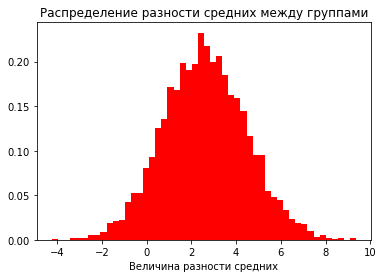

In [22]:
N = 100
X = pd.Series(np.random.binomial(300, 0.7, size = N))
Y_a, Y_b = np.repeat("Experiment", N/2), np.repeat("Control", N/2)
N_a, N_b = len(Y_a), len(Y_b)

Y = pd.Series(np.append(Y_a, Y_b))
data = pd.concat([X,Y],axis = 1)
print(data)
means_per_group = data.groupby(1, group_keys = False)[0].mean()
medians_per_group = data.groupby(1)[0].median()

alpha = 0.05
def bootstrap(data, b_iter):
    boot_mean_diff = []
    boot_medians_diff = []

    boot_means_a = []
    boot_means_b = []

    count_num_positives_meandiff = 0
    count_num_positives_mediandiff = 0

    for i in range(b_iter):

        boot_sample = data.sample(frac = 1, replace = True)

        # Выборочное среднее на этой итерации bootstrap для A и B группы
        boot_means_per_group = boot_sample.groupby(1)[0].mean()
        boot_sample_mean_a = boot_means_per_group["Control"]
        boot_sample_mean_b = boot_means_per_group["Experiment"]

        boot_means_a.append(boot_sample_mean_a)
        boot_means_b.append(boot_sample_mean_b)

        # Разность выборочных средних между группами А и B на этой итерации bootstrap
        diff_means = boot_sample_mean_b - boot_sample_mean_a

        # Считаем кол-во итераций, когда разность средих была положительна
        if diff_means > 0:
            count_num_positives_meandiff += 1

        # Считаем медианы по группам контроля / воздействия
        boot_medians_per_group = boot_sample.groupby(1)[0].median()

        # Считаем кол-во итераций, когда разность медиан была положительна
        diff_medians = boot_medians_per_group["Experiment"] - boot_medians_per_group["Control"]
        if diff_medians > 0:
            count_num_positives_mediandiff += 1

        boot_mean_diff.append(diff_means)
        boot_medians_diff.append(diff_medians)

    return(
        boot_means_a,
        boot_means_b,
        count_num_positives_meandiff,
        count_num_positives_mediandiff,
        boot_mean_diff
    )

b_iter = 5000
X_bars_a, X_bars_b , n_means, n_medians, boot_mean_diff = bootstrap(data, b_iter)
Z_mean = np.mean(X_bars_b)- np.mean(X_bars_a)
Z_sigma = np.sqrt((np.var(X_bars_b)/N_b + np.var(X_bars_a)/N_a))
CI = [Z_mean - norm.ppf(1-alpha/2)*Z_sigma, Z_mean + norm.ppf(1-alpha/2)*Z_sigma]

print("Mean of X_bar_exp - X_bar_con", Z_mean)
print("Standard Error of X_bar_exp - X_bar_con", Z_sigma)
print("CI of X_bar_exp - X_bar_con", CI)

p_value_diff_means = n_means/b_iter
p_value_diff_medians = n_medians/b_iter

CI = np.percentile(boot_mean_diff, [2.5, 97.5])

counts, bins, ignored = plt.hist(
    boot_mean_diff, 50,
    density = True,
    color = 'red'
)
plt.xlabel("Величина разности средних")
plt.title("Распределение разности средних между группами")
plt.show()

In [24]:
import pandas as pd
import numpy as np
import random
import datetime
import os
import scipy.stats as st

In [25]:
def generate_data():
    ''' Функция, генерирующая трафик магазинов по дням с 2019-01-01 по 2019-06-39'''

    ID = random.sample(range(1000001, 100000001), 1000)  # Генерируем уникальные id (восьмизначные числа) для 1'000 магазинов

    mean_daily = 600    # Исходя из того, что в магазины из крупных сетей (около 10'000 магазинов) ежедневный поток
                        # покупателей (далее трафик - traffic) в среднем составляет 1300 человек, предположим, что
                        # для сети в 1'000 магазинов траффик меньше примерно в два раза (из-за убывающей отдачи от масштаба), 
                        # то есть в среднем составляет 600 человек/день

    # Теперь предположим, что ввиду того, что сеть магазинов большая, у каждого магазина есть постоянный и достаточно 
    # стабильный трафик (то есть небольшое стандартное отклонение). Магазины могут быть разными по величине, поэтому 
    # возьмем нормальное распределение по объемам трафика со средним mean_daily и std = 10% от mean_daily
    mean_for_each_id = np.random.normal(loc = mean_daily, scale = 0.1 * mean_daily, size = 1000)

    # Составим датафрейм со средними значениями трафика для каждого магазина.
    traffic_conf_int = pd.DataFrame({'mean_traffic': np.array(list(map(int, mean_for_each_id))),
                                    'lower_bound': np.zeros(len(mean_for_each_id)),
                                    'upper_bound': np.zeros(len(mean_for_each_id)),}, index = ID)

    # Сгенерируем нижнюю и верхнюю границы доверительных интервалов, в которых будет колебаться трафик в каждом магазине
    traffic_conf_int['lower_bound'] = traffic_conf_int['mean_traffic'].map(lambda i: st.norm.interval(0.95,
                                                                                                    loc = i,
                                                                                                    scale = 0.1 * i)[0]).map(int)
    traffic_conf_int['upper_bound'] = traffic_conf_int['mean_traffic'].map(lambda i: st.norm.interval(0.95,
                                                                                                    loc = i,
                                                                                                    scale = 0.1 * i)[1]).map(int)

    # Генерируем данные в промежутке от 2019-01-01 до 2019-06-30.
    date_start = datetime.datetime(2019, 1, 1)
    date_end = datetime.datetime(2019, 6, 30)
    date_index = pd.date_range(date_start, date_end)

    # Создаем для датафрейм дневного трафика в каждом магазине за рассматриваемый промежуток времени.
    right_indexes = pd.MultiIndex.from_product([ID, date_index.to_list()], names=['id', 'date'])

    daily_df = pd.DataFrame({'traffic': np.zeros(len(right_indexes))}, index = right_indexes).reset_index()

    # Соединяем два полученных датафрейма, чтобы сгенерировать случайный дневной трафик для каждого магазина в
    # пределах его доверительного интервала.
    merged_df = pd.merge(daily_df, traffic_conf_int, left_on = 'id', right_index = True, how = 'left', sort=False)

    def foo(x):
        ''' Функция выдает случайное число типа int в границах заданного доверительного интервала'''
    
        traffic = random.randint(merged_df['lower_bound'][x], merged_df['upper_bound'][x])
        return traffic

    # Для каждого магазина генерируем дневной трафик.
    merged_df['traffic'] = merged_df['traffic'].map(foo)

    # Из полученного датафрейма merged_df убираем лишние колонки и получаем готовый сгенерированный датафрейм.
    generated_df = merged_df.drop(['mean_traffic', 'lower_bound', 'upper_bound'], axis = 1)

    return generated_df 


generated_df = generate_data()
# linearized_df = linearize_data(generated_df = generated_df)

In [26]:
generated_df

,id,date,traffic
0,99606020,2019-01-01,445
1,99606020,2019-01-02,566
2,99606020,2019-01-03,447
3,99606020,2019-01-04,529
4,99606020,2019-01-05,520
...,...,...,...
180995,79394544,2019-06-26,472
180996,79394544,2019-06-27,534
180997,79394544,2019-06-28,438
180998,79394544,2019-06-29,394


In [27]:
generated_df['period'] = ''
generated_df.loc[generated_df['date'] >= '2019-04-01','period'] = 'after'
generated_df.loc[generated_df['date'] < '2019-04-01','period'] = 'before'


In [28]:
dict_ = {
    0: [],
    1: []
}
for i in list(generated_df.id.unique()):
    grp = int(np.random.randint(0, 2, 1))
    dict_[grp].append(i)

In [29]:
generated_df.loc[generated_df['id'].isin(dict_[0]), 'group'] = 'A'
generated_df.loc[generated_df['id'].isin(dict_[1]), 'group'] = 'B'

In [30]:
df_t = (
    generated_df
    .groupby(['date', 'group', 'period'])
    .agg(
        {'traffic': sum}
    )
    .reset_index()
)

In [31]:
df_t

,date,group,period,traffic
0,2019-01-01,A,before,222571
1,2019-01-01,B,before,256892
2,2019-01-02,A,before,223103
3,2019-01-02,B,before,258061
4,2019-01-03,A,before,225510
...,...,...,...,...
357,2019-06-28,B,after,257002
358,2019-06-29,A,after,225116
359,2019-06-29,B,after,255914
360,2019-06-30,A,after,223731


group
A    AxesSubplot(0.125,0.125;0.775x0.755)
B    AxesSubplot(0.125,0.125;0.775x0.755)
Name: traffic, dtype: object

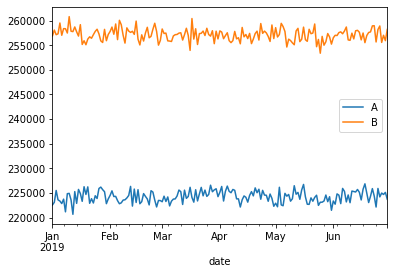

In [75]:
df_t.set_index('date', inplace=True)
df_t.groupby('group')['traffic'].plot(legend=True)
# df_t.groupby('group').agg({'traffic': sum}).plot(legend=True)
# plt.plot(df_t.date, df_t.traffic, color=df_t.group)

## Ranking

In [4]:
df_r = df_t.drop(['period', 'date'], axis=1)

NameError: name 'df_t' is not defined

In [33]:
df_r[df_r.group == 'A'].traffic.std(), df_r[df_r.group == 'B'].traffic.std()

(1222.524964048804, 1272.235521328941)

In [34]:
df_r.loc[df_r.group == 'A','rank'] = df_r[df_r.group == 'A'].traffic.rank()
df_r.loc[df_r.group == 'B','rank'] = df_r[df_r.group == 'B'].traffic.rank()

In [35]:
df_r[df_r.group == 'A']['rank'].std(), df_r[df_r.group == 'B']['rank'].std()

(52.39420557445048, 52.394232082888244)

In [43]:
ttest = ttest_ind(
    df_r[df_r.group == 'A'].traffic, 
    df_r[df_r.group == 'B'].traffic,
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)
ttest_r = ttest_ind(
    df_r[df_r.group == 'A']['rank'], 
    df_r[df_r.group == 'B']['rank'],
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)
mwtest = mannwhitneyu(
    df_r[df_r.group == 'A'].traffic, 
    df_r[df_r.group == 'B'].traffic
#     nan_policy='propagate',
#     alternative='two-sided'
)
print(ttest,'\n', ttest_r, '\n', mwtest)

Ttest_indResult(statistic=-250.4742787859884, pvalue=0.0) 
 Ttest_indResult(statistic=0.0, pvalue=1.0) 
 MannwhitneyuResult(statistic=0.0, pvalue=7.843965937156977e-61)


## Logarithm

In [44]:
import math

In [45]:
df_l = df_t.drop(['period', 'date'], axis=1)

In [46]:
df_l[df_l.group == 'A'].traffic.std(), df_l[df_l.group == 'B'].traffic.std()

(1222.524964048804, 1272.235521328941)

In [47]:
df_l.loc[df_l.group == 'A','log'] = df_l[df_l.group == 'A'].traffic.map(lambda x: math.log(x))
df_l.loc[df_l.group == 'B','log'] = df_l[df_l.group == 'B'].traffic.map(lambda x: math.log(x))

In [48]:
df_l[df_l.group == 'A']['log'].std(), df_l[df_l.group == 'B']['log'].std()

(0.005453118240968117, 0.004947442698545993)

In [49]:
ttest = ttest_ind(
    df_l[df_l.group == 'A'].traffic, 
    df_l[df_l.group == 'B'].traffic,
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)

ttest_l = ttest_ind(
    df_l[df_l.group == 'A']['log'], 
    df_l[df_l.group == 'B']['log'],
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)
# mwtest = mannwhitneyu(
#     df_r[df_r.group == 'A'].traffic, 
#     df_r[df_r.group == 'B'].traffic
# #     nan_policy='propagate',
# #     alternative='two-sided'
# )
print(ttest,'\n',ttest_l)

Ttest_indResult(statistic=-250.4742787859884, pvalue=0.0) 
 Ttest_indResult(statistic=-249.76305119117558, pvalue=0.0)


## Normalisation

In [50]:
df_norm = df_t.drop(['period', 'date'], axis=1)

In [51]:
df_norm[df_norm.group == 'A'].traffic.std(), df_norm[df_norm.group == 'B'].traffic.std()

(1222.524964048804, 1272.235521328941)

In [52]:
grp_a_max = df_norm[df_norm.group == 'A'].traffic.max()
grp_a_min = df_norm[df_norm.group == 'A'].traffic.min()
grp_b_max = df_norm[df_norm.group == 'B'].traffic.max()
grp_b_min = df_norm[df_norm.group == 'B'].traffic.min()
df_norm.loc[
    df_norm.group == 'A','norm'
] = df_norm[df_norm.group == 'A'].traffic.map(lambda x: (x-grp_a_min)/(grp_a_max - grp_a_min))
df_norm.loc[
    df_norm.group == 'B','norm'
] = df_norm[df_norm.group == 'B'].traffic.map(lambda x: (x-grp_b_min)/(grp_b_max - grp_b_min))

In [53]:
df_norm[df_norm.group == 'A']['norm'].std(), df_norm[df_norm.group == 'B']['norm'].std()

(0.19756382741577314, 0.17143720810253893)

In [54]:
ttest = ttest_ind(
    df_norm[df_norm.group == 'A'].traffic, 
    df_norm[df_norm.group == 'B'].traffic,
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)
ttest_norm = ttest_ind(
    df_norm[df_norm.group == 'A']['norm'], 
    df_norm[df_norm.group == 'B']['norm'],
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)
mwtest = mannwhitneyu(
    df_r[df_r.group == 'A'].traffic, 
    df_r[df_r.group == 'B'].traffic
#     nan_policy='propagate',
#     alternative='two-sided'
)
print(ttest,'\n',ttest_norm)

Ttest_indResult(statistic=-250.4742787859884, pvalue=0.0) 
 Ttest_indResult(statistic=3.91424237471565, pvalue=0.00010845677247182772)


## Standartization

In [55]:
df_st = df_t.drop(['period', 'date'], axis=1)

In [56]:
df_st[df_st.group == 'A'].traffic.std(), df_st[df_st.group == 'B'].traffic.std()

(1222.524964048804, 1272.235521328941)

In [57]:
grp_a_std = df_st[df_st.group == 'A'].traffic.std()
grp_a_mean = df_st[df_st.group == 'A'].traffic.mean()
grp_b_std = df_st[df_st.group == 'B'].traffic.std()
grp_b_mean = df_st[df_st.group == 'B'].traffic.mean()
df_st.loc[
    df_st.group == 'A','st'
] = df_st[df_st.group == 'A'].traffic.map(lambda x: (x-grp_a_mean)/ grp_a_std)
df_st.loc[
    df_st.group == 'B','st'
] = df_st[df_st.group == 'B'].traffic.map(lambda x: (x-grp_b_std)/grp_b_std)

In [68]:
grp_a_mean, grp_b_mean

(224268.88950276244, 257118.02209944752)

In [58]:
df_st[df_st.group == 'A']['st'].std(), df_st[df_st.group == 'B']['st'].std()

(1.0000000000000002, 0.9999999999999999)

In [59]:
ttest = ttest_ind(
    df_st[df_st.group == 'A'].traffic, 
    df_st[df_st.group == 'B'].traffic,
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)
ttest_st = ttest_ind(
    df_st[df_st.group == 'A']['st'], 
    df_st[df_st.group == 'B']['st'],
    equal_var=True,
    nan_policy='propagate',
    alternative='two-sided'
)
mwtest = mannwhitneyu(
    df_st[df_st.group == 'A'].traffic, 
    df_st[df_st.group == 'B'].traffic
#     nan_policy='propagate',
#     alternative='two-sided'
)
mwtest_st = mannwhitneyu(
    df_st[df_st.group == 'A']['st'], 
    df_st[df_st.group == 'B']['st']
#     nan_policy='propagate',
#     alternative='two-sided'
)
print(ttest,'\n',ttest_st)
print(mwtest,'\n',mwtest_st)

Ttest_indResult(statistic=-250.4742787859884, pvalue=0.0) 
 Ttest_indResult(statistic=-1913.0884144827346, pvalue=0.0)
MannwhitneyuResult(statistic=0.0, pvalue=7.843965937156977e-61) 
 MannwhitneyuResult(statistic=0.0, pvalue=7.843965937156977e-61)


## Linearization

In [123]:
def linearize_data(generated_df):
    ''' Функция, осуществляющая линеаризацию на сгенерированных данных '''

    # Для проведения линеаризации добавим дополнительный столбец is_pilot - индикатор для обозначения пилотного периода
    # в новый датафрейм pre_linearized_df.
    pre_linearized_df = pd.concat([generated_df, pd.Series(np.zeros(len(generated_df))).map(int).rename('is_pilot')], axis=1)

    pre_linearized_df.loc[pre_linearized_df.date >= '2019-04-01', 'is_pilot'] =  1

    # Вычислим средние значения трафика до и во время пилотного периода для каждого магазина в mean_by_is_pilot
    mean_by_is_pilot = pre_linearized_df.groupby(['id', 'is_pilot']).mean().reset_index()

    # Оставим в новом датафрейме mean_not_pilot средние значения трафика в магазинах до пилотного периода.
    mean_not_pilot = mean_by_is_pilot[mean_by_is_pilot['is_pilot'] == 0]
    mean_not_pilot = mean_not_pilot.assign(mean_traffic = np.array(mean_not_pilot['traffic'].map(int)))
    mean_not_pilot = mean_not_pilot.drop(['traffic', 'is_pilot'], axis = 1)  # Убираем лишние столбцы

    # Соединяем сгенерированный датафрейм со столбцом is_pilot (pre_linearized_df) с полученным датафреймом значений
    # среднего трафика магазинов до пилотного периода.
    linearized_df = pd.merge(pre_linearized_df, mean_not_pilot, left_on = 'id', right_on = 'id', how = 'left', sort = False)

    # Проводим линеаризацию, вычитая средние значения "до"-пилотного периода из сгенерированных значений трафика в
    # пилотном периоде для каждого магазина.
    linearized_df.loc[linearized_df.is_pilot == 1, 'traffic'] =  linearized_df['traffic'] - linearized_df['mean_traffic']
    
    # Убираем лишние столбцы из датафрейма линеаризованного трафика, а также значения "до"-пилотного периода
    linearized_df = linearized_df[linearized_df['is_pilot']== 1].drop(['is_pilot','mean_traffic'],axis = 1) 
    
    return linearized_df 

In [124]:
generated_df

,id,date,traffic,period,group
0,99606020,2019-01-01,445,before,A
1,99606020,2019-01-02,566,before,A
2,99606020,2019-01-03,447,before,A
3,99606020,2019-01-04,529,before,A
4,99606020,2019-01-05,520,before,A
...,...,...,...,...,...
180995,79394544,2019-06-26,472,after,B
180996,79394544,2019-06-27,534,after,B
180997,79394544,2019-06-28,438,after,B
180998,79394544,2019-06-29,394,after,B


In [125]:
df_t.groupby('group').agg({'traffic': np.std}).reset_index()

,group,traffic
0,A,1222.524964
1,B,1272.235521


In [126]:
lin_dt = linearize_data(generated_df)

In [127]:
lin_dt.groupby('group').agg({'traffic': np.std}).reset_index()

,group,traffic
0,A,55.337669
1,B,55.059115


## CUPED

In [91]:
id_mean_df = generated_df.groupby(['id', 'period', 'group']).agg({'traffic': np.mean}).reset_index()

In [92]:
id_mean_df_before = id_mean_df[id_mean_df.period=='before']
id_mean_df_after = id_mean_df[id_mean_df.period!='before']

In [95]:
id_mean_df_final = (
    pd.merge(id_mean_df_before, id_mean_df_after, how='inner', on='id')
    .rename({
        'traffic_x': 'traffic_before', 
        'traffic_y': 'traffic_after',
        'group_x': 'group'
    }, axis=1)
    .drop(['period_x', 'period_y', 'group_y'], axis=1)
)

In [116]:
id_mean_df_final

,id,group,traffic_before,traffic_after,traffic_after_tilde,treatment,traffic_after_cuped
0,1188823,B,477.388889,493.472527,493.456809,1,493.456809
1,1359541,B,489.555556,481.516484,481.547493,1,481.547493
2,1390240,B,471.233333,481.604396,481.565035,1,481.565035
3,1427091,A,482.922222,476.758242,476.763775,0,476.763775
4,1458667,A,466.933333,485.615385,485.559509,0,485.559509
...,...,...,...,...,...,...,...
995,99472728,A,480.044444,485.461538,485.456019,0,485.456019
996,99594911,A,473.122222,475.417582,475.385477,0,475.385477
997,99599226,A,487.755556,477.989011,478.013108,0,478.013108
998,99606020,A,470.822222,474.626374,474.585434,0,474.585434


In [107]:
id_mean_df_final['treatment'] = (id_mean_df_final['group']=='B').astype(int)

In [97]:
import statsmodels.formula.api as smf

### Two similar ways to make Ŷ₁ᶜᵘᵖᵉᵈ (1 way)

In [128]:
## Regress Y₁ on Y₀ and compute the residuals Ỹ₁ + Compute Ŷ₁ᶜᵘᵖᵉᵈ = Ỹ₁ + Y̅₁
id_mean_df_final['traffic_after_tilde'] = (
    smf.ols(
        'traffic_after ~ traffic_before', 
        data=id_mean_df_final
    ).fit().resid + np.mean(id_mean_df_final['traffic_after'])
)

In [129]:
smf.ols(
    'traffic_after_tilde ~ treatment', data=id_mean_df_final
).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,481.4049,0.259,1861.281,0.000,480.897,481.912
treatment,-0.2091,0.354,-0.591,0.555,-0.904,0.485


### Two similar ways to make Ŷ₁ᶜᵘᵖᵉᵈ (2 way)

In [131]:
### Regression of Y₁ ~ Y₀ and theta estimation
theta = smf.ols('traffic_after ~ traffic_before', data=id_mean_df_final).fit().params[1]
print(f'Theta:{theta}')

np.cov(
    id_mean_df_final.traffic_after, 
    id_mean_df_final.traffic_before
)[0][1]/(id_mean_df_final.traffic_before.var())

Theta:-0.003840712466685714


-0.0038407124666847378

In [132]:
###  Ŷ₁ᶜᵘᵖᵉᵈ = Y̅₁ − θ̂ Y̅₀
id_mean_df_final['traffic_after_cuped'] = (
    id_mean_df_final['traffic_after'] - theta * (id_mean_df_final['traffic_before'] - np.mean(id_mean_df_final['traffic_before']))
)

In [133]:
smf.ols('traffic_after_cuped ~ treatment', data=id_mean_df_final).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,481.4049,0.259,1861.281,0.000,480.897,481.912
treatment,-0.2091,0.354,-0.591,0.555,-0.904,0.485
